In [1]:
import gensim.downloader 
import ast
import pandas as pd
import numpy as np


# Show all available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [2]:
if 'model' not in globals():
    model = gensim.downloader.load('word2vec-google-news-300')

In [3]:
#Read in data and convert tokens to list
INFILE = 'data/test_postprocessed_data2.csv'
data = pd.read_csv(INFILE)
data['token_list'] = data['tokens'].apply(lambda x: ast.literal_eval(x))


In [4]:
data.head()

,Unnamed: 0,account,profile_name,id,following,likes,posts_count,followers,is_verified,datetime,...,video_url,timestamp,adultScore,racyScore,goreScore,isBWImg,clipArtType,lineDrawingType,tokens,token_list
0,0,moonlight.homebakery,Moonlight home bakery,2604477449452159164,17,4,6,25,NaN,1624697928,...,NaN,2021-11-06T16:00:29.286Z,0.001595,0.002362,0.002192,False,0,0,"['White', 'Brown', 'food', 'indoor', 'indoor',...","[White, Brown, food, indoor, indoor, plastic, ..."
1,1,moonlight.homebakery,Moonlight home bakery,2676982748423831998,17,17,6,25,NaN,1633341233,...,NaN,2021-11-06T16:00:29.286Z,0.001063,0.002010,0.000863,False,0,0,"['White', 'Brown', 'dessert', 'food', 'baked g...","[White, Brown, dessert, food, baked goods, cak..."
2,2,moonlight.homebakery,Moonlight home bakery,2624004213020042158,17,8,6,25,NaN,1627025699,...,NaN,2021-11-06T16:00:29.286Z,0.001228,0.002200,0.001036,False,0,0,"['White', 'birthday cake', 'dessert', 'baked g...","[White, birthday cake, dessert, baked goods, c..."
3,3,moonlight.homebakery,Moonlight home bakery,2604482556512284410,17,5,6,25,NaN,1624698536,...,NaN,2021-11-06T16:00:29.286Z,0.003177,0.006238,0.050004,False,0,0,"['Brown', 'White', 'Grey', 'dessert', 'baked g...","[Brown, White, Grey, dessert, baked goods, swe..."
4,4,moonlight.homebakery,Moonlight home bakery,2604481372804106171,17,5,6,25,NaN,1624698395,...,NaN,2021-11-06T16:00:29.286Z,0.001172,0.002121,0.000807,False,0,0,"['Yellow', 'fast food', 'baked goods', 'indoor...","[Yellow, fast food, baked goods, indoor, food,..."


#LAbel Encoder

In [5]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(data['account'])
data['account_label'] = le.transform(data['account'])

In [6]:
data['account_label'].value_counts()

0    63
2    13
1     5
Name: account_label, dtype: int64

In [7]:
pip install  --upgrade gensim --pre

Note: you may need to restart the kernel to use updated packages.


In [8]:
!pip install --upgrade gensim

#Data Cleaning

In [9]:
import gensim.parsing.preprocessing as pp
#Remove stop words
my_stop_words = pp.STOPWORDS.union(set(['a', 'of', 'to', 'next', 'and']))
data['tokens_removed_stops'] = data['token_list'].apply(pp.remove_stopword_tokens, stopwords=my_stop_words)

#Split words if multiple in string
def split_list(list):
    words = []
    for word in list:
        split = word.split(' ')
        [words.append(s) for s in split]
    return words
data['tokens_removed_stops'] = data['tokens_removed_stops'].apply(split_list)


#Lower case
def lower_case(list):
    words = []
    for word in list:
        lower = word.lower()
        words.append(lower)
    return words
data['tokens_removed_stops'] = data['tokens_removed_stops'].apply(lower_case)



In [10]:
# # Download Wordnet through NLTK in python console:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jackh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
from nltk.stem import WordNetLemmatizer 

# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

#Lower case
def lemmatize(list, lemmatizer):
    words = []
    for word in list:
        lemmed = lemmatizer.lemmatize(word)
        words.append(lemmed)
    return words

data['tokens_removed_stops'] = data['tokens_removed_stops'].apply(lemmatize, lemmatizer=lemmatizer)


In [12]:
i=15
print(data.loc[i,'token_list'])
print(data.loc[i,'tokens_removed_stops'])

['White', 'Grey', 'Black', 'text', 'bottle', 'black and white', 'cylinder', 'solution', 'solvent', 'household supply', 'skin care', 'indoor', 'lotion', 'monochrome', 'text', 'bottle', 'indoor', 'counter', 'cluttered', 'Personal care', 'Cream']
['white', 'grey', 'black', 'text', 'bottle', 'black', 'and', 'white', 'cylinder', 'solution', 'solvent', 'household', 'supply', 'skin', 'care', 'indoor', 'lotion', 'monochrome', 'text', 'bottle', 'indoor', 'counter', 'cluttered', 'personal', 'care', 'cream']


In [13]:
import time

token_list = data['tokens_removed_stops']

dataset = []
all_word_vecs = []
all_post_indices = []
all_words = []
pad_length = 100

posts = {}

null_list = []
for i, test in enumerate(token_list):

    words = []
    embeddings = []
    nulls = []

    for word in test:
        try:
            vec = model[word]
            embeddings.append(vec)
            all_words.append(word)
            all_word_vecs.append(vec)
            all_post_indices.append(i)
            words.append(word)
        except:
            nulls.append(word)
            #print(word, " is not in the corpus.")

    #while len(embedding_list) < pad_length:
    #    embedding_list.append(np.zeros((300,)))
    embeddings = np.array(embeddings)
    posts[i] = {}
    posts[i]['words'] = words
    posts[i]['vecs'] = embeddings
    posts[i]['nulls'] = nulls
    posts[i]['account'] = data.loc[i, 'account']

    #dataset.append(embedding_list)

dataset = np.array(dataset)
all_post_indices = np.array(all_post_indices)
all_words = np.array(all_words)
#print(null_list)

all_word_vecs = np.array(all_word_vecs)

In [14]:
print(all_words.shape)
#print(all_words.shape)

(1338,)


In [15]:
print(all_post_indices)

[ 0  0  0 ... 80 80 80]


In [16]:
pip install --upgrade --user matplotlib

Note: you may need to restart the kernel to use updated packages.


#Plotting

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.cm as cm

stop = 10000

model_tsne = TSNE()
np.set_printoptions(suppress=True)
 
y = model_tsne.fit_transform(all_word_vecs)
condition = np.isin(all_post_indices, [0,1,2,4,5])
Y = y

'''
#Y = y[np.where(condition)]
colors = cm.rainbow(np.linspace(1,max(all_post_indices),1))

plt.scatter(Y[:stop, 0], Y[:stop, 1],alpha=.5, c=colors[:stop])

for i, _ in enumerate(Y):
    word = all_words[i]
    x = Y[:,0]
    y = Y[:,1]
    plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                    textcoords='offset points', ha='right', va='bottom', size=8)
#plt.savefig('plots/word_embeddings_1710.jpg')
'''

C:\Users\jackh\Anaconda3\envs\synther\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\jackh\Anaconda3\envs\synther\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


"\n#Y = y[np.where(condition)]\ncolors = cm.rainbow(np.linspace(1,max(all_post_indices),1))\n\nplt.scatter(Y[:stop, 0], Y[:stop, 1],alpha=.5, c=colors[:stop])\n\nfor i, _ in enumerate(Y):\n    word = all_words[i]\n    x = Y[:,0]\n    y = Y[:,1]\n    plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),\n                    textcoords='offset points', ha='right', va='bottom', size=8)\n#plt.savefig('plots/word_embeddings_1710.jpg')\n"

C:\Users\jackh\Anaconda3\envs\synther\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\jackh\Anaconda3\envs\synther\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
C:\Users\jackh\AppData\Local\Temp/ipykernel_36204/3833560757.py:10: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)
C:\Users\jackh\AppData\Roaming\Python\Python38\site-packages\matplotlib\collections.py:980: RuntimeWa

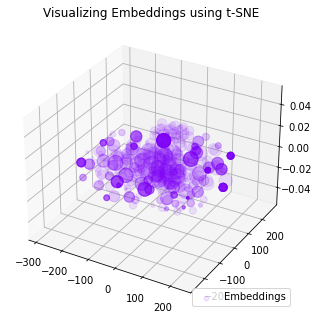

In [18]:
%matplotlib inline
tsne_wp_3d = TSNE(perplexity=30, n_components=3, init='pca', n_iter=3500, random_state=12)
embeddings_wp_3d = tsne_wp_3d.fit_transform(all_word_vecs)

from mpl_toolkits.mplot3d import Axes3D


def tsne_plot_3d(title, label, embeddings, a=1):
    fig = plt.figure()
    ax = Axes3D(fig)
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:, 0]
    y = embeddings[:, 1]
    z = embeddings[:, 2]
    plt.scatter(x, y, z, c=colors, alpha=a, label=label)

    for i, word in enumerate(all_words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)

    plt.legend(loc=4)
    plt.title(title)
    plt.show()


tsne_plot_3d('Visualizing Embeddings using t-SNE', 'Embeddings', embeddings_wp_3d, a=0.1)

In [19]:
Y.shape

(1338, 2)

In [20]:
'''
from nltk.cluster import KMeansClusterer
import nltk
from sklearn import cluster
from sklearn import metrics

X=vec

NUM_CLUSTERS=5
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25 , avoid_empty_clusters=True)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

  
#words=list(model.wv.vocab)
#for i, word in enumerate(words):
#print(word +': '+str(assigned_clusters[i]))

kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(X)
  
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
  
print ("Cluster id labels for inputted data")
print (labels)
print ("Centroids data")
print (centroids)
  
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))
  
silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
  
print ("Silhouette_score: ")
print (silhouette_score)
'''

'\nfrom nltk.cluster import KMeansClusterer\nimport nltk\nfrom sklearn import cluster\nfrom sklearn import metrics\n\nX=vec\n\nNUM_CLUSTERS=5\nkclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25 , avoid_empty_clusters=True)\nassigned_clusters = kclusterer.cluster(X, assign_clusters=True)\n\n  \n#words=list(model.wv.vocab)\n#for i, word in enumerate(words):\n#print(word +\': \'+str(assigned_clusters[i]))\n\nkmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)\nkmeans.fit(X)\n  \nlabels = kmeans.labels_\ncentroids = kmeans.cluster_centers_\n  \nprint ("Cluster id labels for inputted data")\nprint (labels)\nprint ("Centroids data")\nprint (centroids)\n  \nprint ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")\nprint (kmeans.score(X))\n  \nsilhouette_score = metrics.silhouette_score(X, labels, metric=\'euclidean\')\n  \nprint ("Silhouette_score: ")\nprint (silhouet

In [21]:
'''
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
 
model_tsne = TSNE(random_state=0)
np.set_printoptions(suppress=True)
 
Y=model_tsne.fit_transform(all_words)
 
 
plt.scatter(Y[:, 0], Y[:, 1],alpha=.5)


print(Y)
 
for j in range(0,len(sent)):    
   plt.annotate(assigned_clusters[j],xy=(Y[j][0], Y[j][1]),xytext=(0,0),textcoords='offset points')
   print("%s %s" % (assigned_clusters[j],  sent[j]))
 
plt.show()
'''

'\nimport matplotlib.pyplot as plt\nfrom sklearn.manifold import TSNE\n \nmodel_tsne = TSNE(random_state=0)\nnp.set_printoptions(suppress=True)\n \nY=model_tsne.fit_transform(all_words)\n \n \nplt.scatter(Y[:, 0], Y[:, 1],alpha=.5)\n\n\nprint(Y)\n \nfor j in range(0,len(sent)):    \n   plt.annotate(assigned_clusters[j],xy=(Y[j][0], Y[j][1]),xytext=(0,0),textcoords=\'offset points\')\n   print("%s %s" % (assigned_clusters[j],  sent[j]))\n \nplt.show()\n'

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer


for i, post in posts.items():
    x = post.get('full_string', '')
    for word in post['words']:
        if x == '':
            x = word
        else:
            x = x + ' ' + word
    post['full_string'] = x

content = [post['full_string'] for post in posts.values()]
content = np.array(content)

#data['tokens_removed_stops']

tf = TfidfVectorizer()

tfidf_vectors = tf.fit_transform(content)
len(tf.get_feature_names_out())

261

In [23]:
tfidf_vectors.shape

(81, 261)

In [24]:
tfidf_vectors = tfidf_vectors.toarray()

C:\Users\jackh\Anaconda3\envs\synther\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\jackh\Anaconda3\envs\synther\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


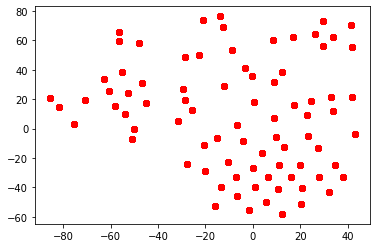

In [25]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
 
model_tsne = TSNE(random_state=0)
np.set_printoptions(suppress=True)
 
initial_tsne=model_tsne.fit_transform(tfidf_vectors)
cols = ['r', 'g', 'b']
 
for i in range(len(initial_tsne)):
    plt.scatter(initial_tsne[:, 0], initial_tsne[:, 1], color=cols[data.loc[i,'account_label']])

In [26]:
from sklearn.decomposition import PCA

# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=30, random_state=22)
pca.fit(tfidf_vectors)
pca_vectors = pca.transform(tfidf_vectors)

In [27]:
pca_vectors.shape

(81, 30)

C:\Users\jackh\Anaconda3\envs\synther\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\jackh\Anaconda3\envs\synther\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


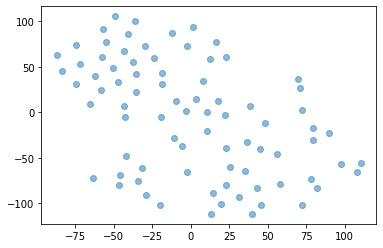

In [28]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
 
model_tsne = TSNE(random_state=0)
np.set_printoptions(suppress=True)
 
pca_tsne=model_tsne.fit_transform(pca_vectors)
 
 
plt.scatter(pca_tsne[:, 0], pca_tsne[:, 1],alpha=.5)

In [29]:
pca_tsne.shape

(81, 2)

In [30]:
vectors_to_cluster = initial_tsne


In [31]:
from sklearn.cluster import KMeans
unique_labels = 3
# cluster feature vectors
kmeans = KMeans(n_clusters=unique_labels, random_state=22)
kmeans.fit(vectors_to_cluster)
names = [post['account'] for post in posts.values()]
# holds the cluster id and the images { id: [images] }
groups = {}
for i, cluster in enumerate(kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(i)
    else:
        groups[cluster].append(i)

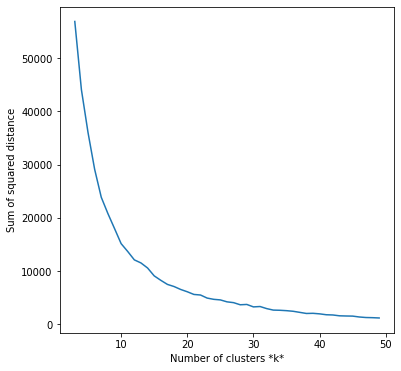

In [32]:
   
# this is just incase you want to see which value for k might be the best 
sse = []
list_k = list(range(3, 50))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22)
    km.fit(vectors_to_cluster)
    
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

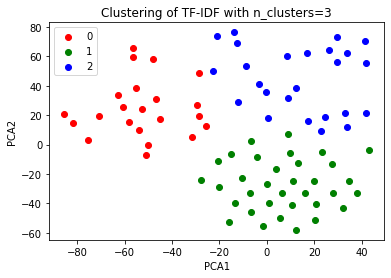

In [33]:
cols = ['r', 'g', 'b']
clusters = [0, 1, 2]
legend_keys = []
for key, indices in groups.items():
    '''
    lab = None
    if key not in legend_keys:
        print(key)
        legend_keys.append(key)
        lab = key
    for post_index in posts:
        plt.scatter(x[post_index][0], x[post_index][1], color=cols[key], label=lab)
    '''
    plt.scatter(vectors_to_cluster[indices][:,0], vectors_to_cluster[indices][:,1], color=cols[key], label=key)

plt.title(f'Clustering of TF-IDF with n_clusters={unique_labels}')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


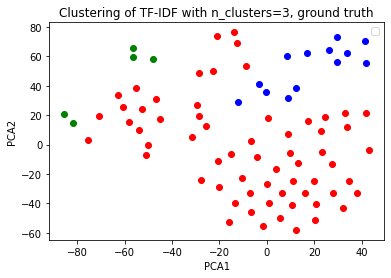

In [34]:
cols = ['r', 'g', 'b']
clusters = [0, 1, 2]
legend_keys = []
for key, indices in groups.items():
    for post_index in indices:
        key = data.loc[post_index, 'account_label']
        plt.scatter(vectors_to_cluster[post_index][0], vectors_to_cluster[post_index][1], color=cols[key])
  

plt.title(f'Clustering of TF-IDF with n_clusters={unique_labels}, ground truth')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

#LSTM

In [35]:
import datetime
data['post datetime']=data['datetime'].apply(datetime.datetime.fromtimestamp)


In [36]:
data.sort_values('post datetime', inplace=True, ascending=True)
data=data.reset_index(drop=True)

In [37]:
data2 = data.loc[:, ['post datetime', 'likes']]

In [38]:
print('The time series starts from: ', data2['post datetime'].min())
print('The time series ends on: ', data2['post datetime'].max())

The time series starts from:  2021-06-26 10:58:48
The time series ends on:  2021-10-29 16:11:50


In [39]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   post datetime  81 non-null     datetime64[ns]
 1   likes          81 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.4 KB


In [40]:
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd
import time

import os

In [41]:
test_cutoff_date = data2['post datetime'].max() - timedelta(days=7)
val_cutoff_date = test_cutoff_date - timedelta(days=14)

df_test = data2[data2['post datetime'] > test_cutoff_date]
df_val = data2[(data2['post datetime'] > val_cutoff_date) & (data2['post datetime'] <= test_cutoff_date)]
df_train = data2[data2['post datetime'] <= val_cutoff_date]

#check out the datasets
print('Test dates: {} to {}'.format(df_test['post datetime'].min(), df_test['post datetime'].max()))
print('Validation dates: {} to {}'.format(df_val['post datetime'].min(), df_val['post datetime'].max()))
print('Train dates: {} to {}'.format(df_train['post datetime'].min(), df_train['post datetime'].max()))


Test dates: 2021-10-27 09:32:13 to 2021-10-29 16:11:50
Validation dates: 2021-10-09 17:04:18 to 2021-10-22 05:58:48
Train dates: 2021-06-26 10:58:48 to 2021-10-07 15:02:52


We want to predict likes at a specified time in the future.

In [42]:
def create_ts_files(dataset, 
                    start_index, 
                    end_index, 
                    history_length, 
                    step_size, 
                    target_step, 
                    num_rows_per_file, 
                    data_folder):
    assert step_size > 0
    assert start_index >= 0
    
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)
    
    time_lags = sorted(range(target_step+1, target_step+history_length+1, step_size), reverse=True)
    col_names = [f'x_lag{i}' for i in time_lags] + ['y']
    start_index = start_index + history_length
    if end_index is None:
        end_index = len(dataset) - target_step
    
    rng = range(start_index, end_index)
    num_rows = len(rng)
    num_files = math.ceil(num_rows/num_rows_per_file)
    
    # for each file.
    print(f'Creating {num_files} files.')
    for i in range(num_files):
        filename = f'{data_folder}/ts_file{i}.pkl'
        
        if i % 10 == 0:
            print(f'{filename}')
            
        # get the start and end indices.
        ind0 = i*num_rows_per_file
        ind1 = min(ind0 + num_rows_per_file, end_index)
        data_list = []
        
        # j in the current timestep. Will need j-n to j-1 for the history. And j + target_step for the target.
        for j in range(ind0, ind1):
            indices = range(j-1, j-history_length-1, -step_size)
            data = dataset[sorted(indices) + [j+target_step]]
            
            # append data to the list.
            data_list.append(data)

        df_ts = pd.DataFrame(data=data_list, columns=col_names)
        df_ts.to_pickle(filename)
            
    return len(col_names)-1


In [43]:
likes = df_train['likes'].values

# Scaled to work with Neural networks.
scaler = MinMaxScaler(feature_range=(0, 1))
likes_scaled = scaler.fit_transform(likes.reshape(-1, 1)).reshape(-1, )

history_length = 7*24*60  # The history length in minutes.
step_size = 10  # The sampling rate of the history. Eg. If step_size = 1, then values from every minute will be in the history.
                #                                       If step size = 10 then values every 10 minutes will be in the history.
target_step = 10  # The time step in the future to predict. Eg. If target_step = 0, then predict the next timestep after the end of the history period.
                  #                                             If target_step = 10 then predict 10 timesteps the next timestep (11 minutes after the end of history).

# The csv creation returns the number of rows and number of features. We need these values below.
num_timesteps = create_ts_files(likes_scaled,
                                start_index=0,
                                end_index=None,
                                history_length=history_length,
                                step_size=step_size,
                                target_step=target_step,
                                num_rows_per_file=128*100,
                                data_folder='ts_data')

Creating 0 files.


In [44]:
class TimeSeriesLoader:
    def __init__(self, ts_folder, filename_format):
        self.ts_folder = ts_folder
        
        # find the number of files.
        i = 0
        file_found = True
        while file_found:
            filename = self.ts_folder + '/' + filename_format.format(i)
            file_found = os.path.exists(filename)
            if file_found:
                i += 1
                
        self.num_files = i
        self.files_indices = np.arange(self.num_files)
        self.shuffle_chunks()
        
    def num_chunks(self):
        return self.num_files
    
    def get_chunk(self, idx):
        assert (idx >= 0) and (idx < self.num_files)
        
        ind = self.files_indices[idx]
        filename = self.ts_folder + '/' + filename_format.format(ind)
        df_ts = pd.read_pickle(filename)
        num_records = len(df_ts.index)
        
        features = df_ts.drop('y', axis=1).values
        target = df_ts['y'].values
        
        # reshape for input into LSTM. Batch major format.
        features_batchmajor = np.array(features).reshape(num_records, -1, 1)
        return features_batchmajor, target
    
    # this shuffles the order the chunks will be outputted from get_chunk.
    def shuffle_chunks(self):
        np.random.shuffle(self.files_indices)


In [45]:
ts_folder = 'ts_data'
filename_format = 'ts_file{}.pkl'
tss = TimeSeriesLoader(ts_folder, filename_format)

##Create keras model LSTM

In [50]:
ts_inputs = tf.keras.Input(shape=(num_timesteps, 1))
ts_inputs

<tf.Tensor 'input_5:0' shape=(None, 1008, 1) dtype=float32>

In [52]:

# units=10 -> The cell and hidden states will be of dimension 10.
#             The number of parameters that need to be trained = 4*units*(units+2)
x = layers.LSTM(10)(ts_inputs)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='linear')(x)
model = tf.keras.Model(inputs=ts_inputs, outputs=outputs)

NotImplementedError: Cannot convert a symbolic Tensor (lstm_2/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])

In [ ]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1008, 1)]         0         
                                                                 
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


##Modeling

In [ ]:
%%time

BATCH_SIZE = 16
NUM_EPOCHS = 1
NUM_CHUNKS = tss.num_chunks()

for epoch in range(NUM_EPOCHS):
    print('epoch #{}'.format(epoch))
    for i in range(NUM_CHUNKS):
        X, y = tss.get_chunk(i)
        
     
        model.fit(x=X, y=y, batch_size=BATCH_SIZE)
        
    # shuffle the chunks so they're not in the same order next time around.
    tss.shuffle_chunks()

epoch #0
CPU times: user 1.96 ms, sys: 0 ns, total: 1.96 ms
Wall time: 7.71 ms


In [ ]:
likes_val = df_val['likes'].values
likes_val_scaled = scaler.transform(likes_val.reshape(-1, 1)).reshape(-1, )

history_length = 7*24*60  # The history length in minutes.
step_size = 10  # The sampling rate of the history. Eg. If step_size = 1, then values from every minute will be in the history.
                #                                       If step size = 10 then values every 10 minutes will be in the history.
target_step = 10  # The time step in the future to predict. Eg. If target_step = 0, then predict the next timestep after the end of the history period.
                  #                                             If target_step = 10 then predict 10 timesteps the next timestep (11 minutes after the end of history).

# The csv creation returns the number of rows and number of features. We need these values below.
num_timesteps = create_ts_files(likes_val_scaled,
                                start_index=0,
                                end_index=None,
                                history_length=history_length,
                                step_size=step_size,
                                target_step=target_step,
                                num_rows_per_file=128*100,
                                data_folder='ts_val_data')

Creating 0 files.


In [ ]:
df_val_ts = pd.read_pickle('ts_val_data/ts_file0.pkl')


features = df_val_ts.drop('y', axis=1).values
features_arr = np.array(features)

# reshape for input into LSTM. Batch major format.
num_records = len(df_val_ts.index)
features_batchmajor = features_arr.reshape(num_records, -1, 1)


y_pred = model.predict(features_batchmajor).reshape(-1, )
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1 ,)

y_act = df_val_ts['y'].values
y_act = scaler.inverse_transform(y_act.reshape(-1, 1)).reshape(-1 ,)

print('validation mean squared error: {}'.format(mean_squared_error(y_act, y_pred)))

#baseline
y_pred_baseline = df_val_ts['x_lag11'].values
y_pred_baseline = scaler.inverse_transform(y_pred_baseline.reshape(-1, 1)).reshape(-1 ,)
print('validation baseline mean squared error: {}'.format(mean_squared_error(y_act, y_pred_baseline)))


FileNotFoundError: ignored